<pre>
<b>HTTP requests to the NASA Kennedy Space Center WWW server</b>

<b>Fonte oficial do dateset:</b>  http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html
Dados:
    
 <a href = 'ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz'>
    ● Jul 01 to Jul 31, ASCII format, 20.7 MB gzip compressed, 205.2 MB</a>
 <a href = 'ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz'>
    ● Aug 04 to Aug 31, ASCII format, 21.8 MB gzip compressed, 167.8 MB.</a>

Sobre o dataset​: Esses dois conjuntos de dados possuem todas as requisições HTTP para o servidor da NASA Kennedy
Space Center WWW na Flórida para um período específico.

Os logs estão em arquivos ASCII com uma linha por requisição com as seguintes colunas:
<b>● Host fazendo a requisição.</b> Um hostname quando possível, caso contrário o endereço de internet se o nome
não puder ser identificado.
<b>● Timestamp</b> no formato "DIA/MÊS/ANO:HH:MM:SS TIMEZONE"
<b>● Requisição(entre aspas)</b>
<b>● Código do retorno HTTP</b>
<b>● Total de bytes retornados</b>

Questões
Responda as seguintes questões devem ser desenvolvidas em Spark utilizando a sua linguagem de preferência.

<b>1. Número de hosts únicos.</b>
<b>2. O total de erros 404.</b>
<b>3. Os 5 URLs que mais causaram erro 404.</b>
<b>4. Quantidade de erros 404 por dia.</b>
<b>5. O total de bytes retornados.</b>

</pre>



<pre>
Fontes de pesquisa:
    
    <a href='https://opensource.com/article/19/5/log-data-apache-spark'>How to wrangle log data with Python and Apache Spark</a>
    <a href='https://opensource.com/article/19/5/visualize-log-data-apache-spark'>How to analyze log data with Python and Apache Spark</a>
    
    
</pre>
        

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import udf
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pandas as pd
import glob
%matplotlib inline

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [3]:
raw_data_files = glob.glob('data/*')
raw_data_files

['data\\access_log_Aug95', 'data\\access_log_Jul95']

In [4]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [5]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [6]:
base_df_rdd =  base_df.rdd

In [7]:
type(base_df_rdd)

pyspark.rdd.RDD

In [8]:
base_df.show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


In [9]:
base_df_rdd.take(10)

[Row(value='in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687'),
 Row(value='piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/l

In [10]:
print((base_df.count(), len(base_df.columns)))

(3461613, 1)


In [11]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0',
 'ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713',
 'uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687',
 'piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/launchmedium.gif HTTP/1.0" 200 11853',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:11 -0400] "GET

<pre><b>Extraindo os Hostnames</b></pre>

In [12]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]

In [13]:
hosts

['in24.inetnebr.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'ix-esc-ca2-07.ix.netcom.com',
 'uplherc.upl.com',
 'slppp6.intermind.net',
 'piweba4y.prodigy.com',
 'slppp6.intermind.net',
 'slppp6.intermind.net',
 'ix-esc-ca2-07.ix.netcom.com',
 'slppp6.intermind.net',
 'uplherc.upl.com',
 '133.43.96.45']

<pre><b>Extraindo os horários</b></pre>

In [14]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Aug/1995:00:00:01 -0400',
 '01/Aug/1995:00:00:07 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:09 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:11 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:13 -0400',
 '01/Aug/1995:00:00:14 -0400',
 '01/Aug/1995:00:00:16 -0400']

<pre><b>Extraindo os requisições HTTP, URL's e protocolos</b></pre>

In [15]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/images/ksclogo-medium.gif', 'HTTP/1.0'),
 ('GET', '/images/MOSAIC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/USA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/launch-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/WORLD-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab.html', 'HTTP/1.0'),
 ('GET', '/images/launchmedium.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab-small.gif', 'HTTP/1.0'),
 ('GET', '/images/ksclogosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo1.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-69/mission-sts-69.html', 'HTTP/1.0')]

<pre><b>Extraindo os códigos HTTP's</b></pre>

In [16]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '304', '304', '304', '304', '200', '304', '200', '200', '200', '200', '200', '200', '304', '200']


<pre><b>Extraindo as respostas HTTP's</b></pre>

In [17]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['1839', '0', '0', '0', '0', '1713', '0', '1687', '11853', '9202', '3635', '1173', '3047', '0', '10566']


<pre><b>Juntando todos os dados</b></pre>

In [18]:
logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|   in24.inetnebr.com|01/Aug/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|                   /|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|
|ix-esc-ca2-07.ix....|01/Aug/1995:00:00...|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/WORLD-log...|HTTP/1.0|   304|    

In [19]:
nullValue = (base_df.filter(base_df['value'].isNull()).count())
nullValue

0

In [20]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()|
                             logs_df['timestamp'].isNull() |
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

<pre><b>Contando valores nulos</b></pre>

In [21]:

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



<pre><b>Manipulando status HTTP's nulos </b></pre>

<pre><b>a=</b></pre>

In [22]:
regexp_extract('value', r'\s(\d{3})\s', 1).cast('integer').alias( 'status')
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [23]:
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [24]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



In [25]:
logs_df = logs_df[logs_df['status'].isNotNull()]
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



In [26]:
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33905

In [27]:
null_content_size_df.take(10)

[Row(value='gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -'),
 Row(value='js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -'),
 Row(value='tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -'),
 Row(value='itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -'),
 Row(value='grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -'),
 Row(value='miriworld.its.unimelb.edu.au - - [01/Aug/1995:01:04:54 -0400] "GET /history/history.htm HTTP/1.0" 404 -'),
 Row(value='ras38.srv.net - - [01/Aug/1995:01:05:14 -0400] "GET /elv/DELTA/uncons.htm HTTP/1.0" 404 -'),
 Row(value='cs1-06.leh.ptd.net - - [01/Aug/1995:01:17:38 -0400] "GET /sts-71/launch/" 404 -'),
 Row(value='www-b2.proxy.aol.com - - [01/Aug/1995:01:22:07 -0400] "GET 

In [28]:
logs_df = logs_df.na.fill({'content_size': 0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



In [29]:

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):

    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )
udf_parse_time = udf(parse_clf_time)

logs_df = (logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp'))


In [30]:
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   in24.inetnebr.com|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|1995-08-01 00:00:01|
|     uplherc.upl.com|   GET|                   /|HTTP/1.0|   304|           0|1995-08-01 00:00:07|
|     uplherc.upl.com|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|1995-08-01 00:00:09|
|     uplherc.upl.com|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|1995-08-01 00:00:10|


In [31]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [32]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

In [33]:
logs_df.show()

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   in24.inetnebr.com|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|1995-08-01 00:00:01|
|     uplherc.upl.com|   GET|                   /|HTTP/1.0|   304|           0|1995-08-01 00:00:07|
|     uplherc.upl.com|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|1995-08-01 00:00:09|
|     uplherc.upl.com|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|1995-08-01 00:00:10|


In [34]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949294
3,min,0
4,max,6823936


In [35]:
(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


In [36]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Códigos HTTP:', status_freq_df.count())  

Códigos HTTP: 8


In [37]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


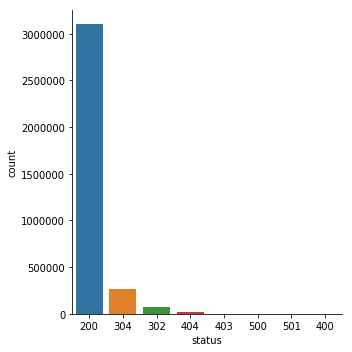

In [38]:
sns.catplot(x='status', y='count', data=status_freq_pd_df,
            kind='bar', order=status_freq_pd_df['status'])

In [39]:
log_freq_df = status_freq_df.withColumn('log(count)',
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



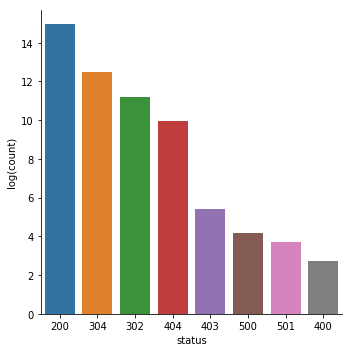

In [40]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df,
            kind='bar', order=status_freq_pd_df['status'])

In [41]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



In [42]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

In [43]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df  

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


In [44]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error_endpoints_freq_df.show(truncate=False)  

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



In [45]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

In [46]:
logs_df.show()

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   in24.inetnebr.com|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|1995-08-01 00:00:01|
|     uplherc.upl.com|   GET|                   /|HTTP/1.0|   304|           0|1995-08-01 00:00:07|
|     uplherc.upl.com|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|1995-08-01 00:00:09|
|     uplherc.upl.com|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|1995-08-01 00:00:10|


In [47]:
logs_df.host

Column<b'host'>

In [48]:
host_day_df = logs_df.select(logs_df.host,F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+-----------------+---+
|host             |day|
+-----------------+---+
|in24.inetnebr.com|1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
+-----------------+---+
only showing top 5 rows



In [49]:
host_day_df = logs_df.select(logs_df.host,
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+-----------------+---+
|host             |day|
+-----------------+---+
|in24.inetnebr.com|1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
|uplherc.upl.com  |1  |
+-----------------+---+
only showing top 5 rows



In [50]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df.groupBy('day').count().sort("day"))
daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

NameError: name 'host_day_distinct_df' is not defined

In [52]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_df,
                kind='point', height=5,
                aspect=1.5)

NameError: name 'daily_hosts_df' is not defined

In [53]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"),
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"),
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

NameError: name 'host_day_distinct_df' is not defined

In [54]:
c = sns.catplot(x='day', y='avg_reqs',
                data=avg_daily_reqests_per_host_df,
                kind='point', height=5, aspect=1.5)

NameError: name 'avg_daily_reqests_per_host_df' is not defined

In [55]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


In [56]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

In [57]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|dialip-217.den.mmc.com     |62   |
|www-b4.proxy.aol.com       |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



<pre><b>Erros 404 por dia </b></pre>

In [58]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


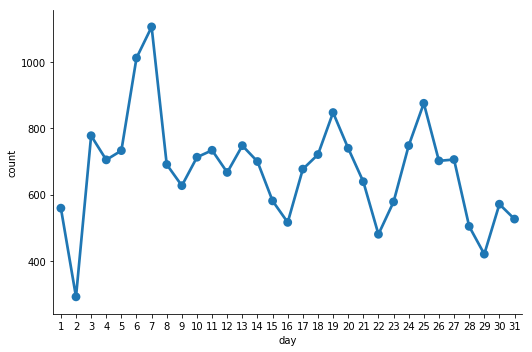

In [59]:
c = sns.catplot(x='day', y='count',
                data=errors_by_date_sorted_pd_df,
                kind='point', height=5, aspect=1.5)

In [60]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



<pre><b>Visualizando os erros 404 por hora</b></pre>

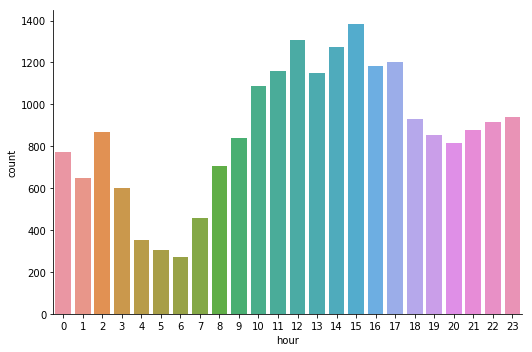

In [61]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count',
                data=hourly_avg_errors_sorted_pd_df,
                kind='bar', height=5, aspect=1.5)